In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
plt.style.use('fivethirtyeight')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv(r'_input/train.csv')
test = pd.read_csv(r'_input/test.csv')

In [3]:
train.shape, test.shape

((20758, 18), (13840, 17))

In [4]:
train.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

In [6]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,20758.0,10378.500000,5992.462780,0.00,5189.250000,10378.500000,15567.750000,20757.000000
Age,20758.0,23.841804,5.688072,14.00,20.000000,22.815416,26.000000,61.000000
Height,20758.0,1.700245,0.087312,1.45,1.631856,1.700000,1.762887,1.975663
Weight,20758.0,87.887768,26.379443,39.00,66.000000,84.064875,111.600553,165.057269
FCVC,20758.0,2.445908,0.533218,1.00,2.000000,2.393837,3.000000,3.000000
NCP,20758.0,2.761332,0.705375,1.00,3.000000,3.000000,3.000000,4.000000
CH2O,20758.0,2.029418,0.608467,1.00,1.792022,2.000000,2.549617,3.000000
FAF,20758.0,0.981747,0.838302,0.00,0.008013,1.000000,1.587406,3.000000
TUE,20758.0,0.616756,0.602113,0.00,0.000000,0.573887,1.000000,2.000000


In [7]:
train.duplicated().sum(), test.duplicated().sum()

(0, 0)

In [8]:
# Preprocessing
train['NObeyesdad'].value_counts()

Obesity_Type_III       4046
Obesity_Type_II        3248
Normal_Weight          3082
Obesity_Type_I         2910
Insufficient_Weight    2523
Overweight_Level_II    2522
Overweight_Level_I     2427
Name: NObeyesdad, dtype: int64

In [9]:
labels_encoded = pd.DataFrame(train['NObeyesdad'])
dict_conversion = {'Insufficient_Weight':0,
                   'Normal_Weight':1,
                   'Overweight_Level_I':2,
                   'Overweight_Level_II':3,
                   'Obesity_Type_I':4,
                   'Obesity_Type_II':5,
                   'Obesity_Type_III':6}

labels_encoded['NObeyesdad'] = labels_encoded['NObeyesdad'].map(dict_conversion)

In [10]:
features = train.drop(['NObeyesdad', 'id'], axis=1)

In [11]:
features.shape

(20758, 16)

In [12]:
corr = features.corr()
corr.style.background_gradient(cmap='coolwarm')
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
Age,1.00,-0.01,0.28,0.03,-0.05,-0.02,-0.19,-0.30
Height,-0.01,1.00,0.42,-0.07,0.19,0.18,0.30,0.08
Weight,0.28,0.42,1.00,0.25,0.10,0.32,-0.08,-0.09
FCVC,0.03,-0.07,0.25,1.00,0.11,0.10,-0.09,-0.15
NCP,-0.05,0.19,0.10,0.11,1.00,0.08,0.10,0.07
CH2O,-0.02,0.18,0.32,0.10,0.08,1.00,0.08,-0.01
FAF,-0.19,0.30,-0.08,-0.09,0.10,0.08,1.00,0.02
TUE,-0.30,0.08,-0.09,-0.15,0.07,-0.01,0.02,1.00


In [13]:
features.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation


In [14]:
# encode categorical features
def categorical_features(df):
    # Binary categorical features
    df_binary = pd.DataFrame()
    df_binary['Gender'] = df['Gender'].map({'Male':0, 'Female':1})
    df_binary['family_history_with_overweight'] = df['family_history_with_overweight'].map({'no':0, 'yes':1})
    df_binary['FAVC'] = df['FAVC'].map({'no':0, 'yes':1})
    df_binary['SMOKE'] = df['SMOKE'].map({'no':0, 'yes':1})
    df_binary['SCC'] = df['SCC'].map({'no':0, 'yes':1})
    
    # Ordinal categorical variables
    df_ordinal = pd.DataFrame()
    df_ordinal['CAEC'] = df['CAEC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
    df_ordinal['CALC'] = df['CALC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})

    # one-hot encoding Nominal categorical variable with multiple values
    df_onehot = pd.get_dummies(df['MTRANS'])

    return pd.concat([df_binary, df_ordinal, df_onehot], axis=1)

# scale numerical features
def scale_numerical_cols(df):
    cols_to_scale = df.select_dtypes(include=['int64', 'float64']).columns
    df_scaled = df[cols_to_scale]
    # Applying Quantile Transformer
    transformer = QuantileTransformer(output_distribution='normal')
    df_scaled[cols_to_scale] = transformer.fit_transform(df[cols_to_scale])
    return df_scaled


categorical_encoded = categorical_features(features)
numerical_scaled = scale_numerical_cols(features)

features_encoded = pd.concat([categorical_encoded, numerical_scaled], axis=1)

In [15]:
features_encoded

,Gender,family_history_with_overweight,FAVC,SMOKE,SCC,CAEC,CALC,Automobile,Bike,Motorbike,Public_Transportation,Walking,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
0,0,1,1,0,0,1,1,0,0,0,1,0,0.328223,-0.106869,-0.119299,-0.662724,-0.781370,1.023659,-5.199338,0.381946
1,1,1,1,0,0,2,0,1,0,0,0,0,-1.301191,-1.575613,-1.016672,-0.662724,0.205941,-0.121995,0.106841,0.697507
2,1,1,1,0,0,1,0,0,0,0,1,0,-1.301191,0.134645,-1.330945,-1.613770,-1.185023,-0.615405,-0.273987,1.421129
3,1,1,1,0,0,1,1,0,0,0,1,0,-0.535083,0.128632,1.586933,5.199338,0.205941,-0.731515,0.602972,0.175513
4,0,1,1,0,0,1,1,0,0,0,1,0,1.310017,2.747453,0.188033,0.096596,-1.076251,-0.565104,0.867791,0.344890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,0,1,1,0,0,1,1,0,0,0,1,0,0.392601,0.735604,0.918787,0.230353,0.205941,0.414863,0.525739,-0.269493
20754,0,0,1,0,0,2,1,0,0,0,1,0,-1.301191,0.115678,-1.439001,5.199338,5.199338,-5.199338,1.176890,0.697507
20755,0,1,1,0,0,1,0,0,0,0,1,0,-0.590949,1.327982,0.508949,0.003764,0.205941,-0.121995,0.448870,1.136926
20756,0,1,1,0,0,1,0,1,0,0,0,0,1.513247,-0.028859,-0.015854,0.094747,-1.076251,0.408452,-5.199338,0.380641


In [16]:
corr = features_encoded.corr()
corr.style.background_gradient(cmap='coolwarm')
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Gender,family_history_with_overweight,FAVC,SMOKE,SCC,CAEC,CALC,Automobile,Bike,Motorbike,Public_Transportation,Walking,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
Gender,1.00,-0.10,-0.02,-0.06,0.06,0.05,0.04,-0.15,-0.02,-0.02,0.17,-0.06,-0.05,-0.61,-0.14,0.43,-0.05,-0.13,-0.26,0.02
family_history_with_overweight,-0.10,1.00,0.15,0.02,-0.17,-0.20,-0.00,0.10,-0.03,-0.01,-0.06,-0.09,0.31,0.23,0.53,0.01,0.02,0.17,-0.07,0.08
FAVC,-0.02,0.15,1.00,-0.02,-0.11,-0.12,0.08,0.01,-0.03,-0.02,0.04,-0.12,0.07,0.12,0.22,-0.02,0.01,0.01,-0.05,0.09
SMOKE,-0.06,0.02,-0.02,1.00,0.02,0.02,0.02,0.02,0.03,0.03,-0.02,-0.00,0.06,0.07,0.04,-0.03,0.01,-0.00,0.01,-0.02
SCC,0.06,-0.17,-0.11,0.02,1.00,0.10,0.00,-0.03,0.01,0.01,0.01,0.04,-0.14,-0.10,-0.19,0.04,0.02,-0.02,0.06,-0.04
CAEC,0.05,-0.20,-0.12,0.02,0.10,1.00,-0.07,-0.05,0.01,0.02,0.01,0.07,-0.18,-0.07,-0.34,0.04,0.12,-0.12,0.05,-0.00
CALC,0.04,-0.00,0.08,0.02,0.00,-0.07,1.00,-0.00,0.01,-0.02,0.01,-0.03,0.11,0.09,0.21,0.15,0.05,0.06,-0.07,0.01
Automobile,-0.15,0.10,0.01,0.02,-0.03,-0.05,-0.00,1.00,-0.02,-0.02,-0.92,-0.07,0.48,0.05,0.01,-0.15,0.03,-0.05,-0.03,-0.24
Bike,-0.02,-0.03,-0.03,0.03,0.01,0.01,0.01,-0.02,1.00,-0.00,-0.08,-0.01,0.01,0.01,-0.02,-0.01,0.00,0.03,0.02,-0.02
Motorbike,-0.02,-0.01,-0.02,0.03,0.01,0.02,-0.02,-0.02,-0.00,1.00,-0.09,-0.01,0.01,0.00,-0.02,0.01,0.00,0.02,0.01,-0.02


In [17]:
features_encoded

,Gender,family_history_with_overweight,FAVC,SMOKE,SCC,CAEC,CALC,Automobile,Bike,Motorbike,Public_Transportation,Walking,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
0,0,1,1,0,0,1,1,0,0,0,1,0,0.328223,-0.106869,-0.119299,-0.662724,-0.781370,1.023659,-5.199338,0.381946
1,1,1,1,0,0,2,0,1,0,0,0,0,-1.301191,-1.575613,-1.016672,-0.662724,0.205941,-0.121995,0.106841,0.697507
2,1,1,1,0,0,1,0,0,0,0,1,0,-1.301191,0.134645,-1.330945,-1.613770,-1.185023,-0.615405,-0.273987,1.421129
3,1,1,1,0,0,1,1,0,0,0,1,0,-0.535083,0.128632,1.586933,5.199338,0.205941,-0.731515,0.602972,0.175513
4,0,1,1,0,0,1,1,0,0,0,1,0,1.310017,2.747453,0.188033,0.096596,-1.076251,-0.565104,0.867791,0.344890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,0,1,1,0,0,1,1,0,0,0,1,0,0.392601,0.735604,0.918787,0.230353,0.205941,0.414863,0.525739,-0.269493
20754,0,0,1,0,0,2,1,0,0,0,1,0,-1.301191,0.115678,-1.439001,5.199338,5.199338,-5.199338,1.176890,0.697507
20755,0,1,1,0,0,1,0,0,0,0,1,0,-0.590949,1.327982,0.508949,0.003764,0.205941,-0.121995,0.448870,1.136926
20756,0,1,1,0,0,1,0,1,0,0,0,0,1.513247,-0.028859,-0.015854,0.094747,-1.076251,0.408452,-5.199338,0.380641


In [18]:
# split the data 
X_train, X_validation, y_train, y_validation = train_test_split(features_encoded, labels_encoded, test_size=0.2, random_state=42)

In [19]:
names = [
    "LGBMClassifier",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes"
]

classifiers = [
    lgb.LGBMClassifier(boosting_type='gbdt',device='gpu', objective='multiclass', verbose= -100, num_class=len(np.unique(y_train))),
    SVC(kernel="linear", random_state=42),
    SVC(kernel='rbf', random_state=42),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    MLPClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    GaussianNB()
]

In [23]:
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)

    score_train = round(clf.score(X_train, y_train), 2)
    score_valid = round(clf.score(X_validation, y_validation), 2)
    
    print(name, score_train, score_valid)

LGBMClassifier 0.98 0.9
Linear SVM 0.86 0.86
RBF SVM 0.86 0.83
Decision Tree 1.0 0.85
Random Forest 1.0 0.89
Neural Net 0.9 0.87
AdaBoost 0.42 0.43
Naive Bayes 0.61 0.61


In [24]:
for name, clf in zip(names, classifiers):
    scores = cross_val_score(clf, X_train, y_train, cv=10)
    score_train = (round(scores.mean(), 2), round(scores.std(), 2))

    scores = cross_val_score(clf, X_validation, y_validation, cv=10)
    score_valid = (round(scores.mean(), 2), round(scores.std(), 2))
    
    print(name, score_train, score_valid)

LGBMClassifier (0.91, 0.01) (0.89, 0.01)
Linear SVM (0.86, 0.01) (0.86, 0.01)
RBF SVM (0.83, 0.01) (0.76, 0.02)
Decision Tree (0.85, 0.01) (0.84, 0.01)
Random Forest (0.9, 0.01) (0.87, 0.02)
Neural Net (0.88, 0.01) (0.85, 0.01)
AdaBoost (0.42, 0.01) (0.47, 0.06)
Naive Bayes (0.6, 0.02) (0.55, 0.02)


In [20]:
# specify the base model
clf = lgb.LGBMClassifier(boosting_type='gbdt',device='gpu', objective='multiclass', verbose= -100, num_class=len(np.unique(y_train)))

# train the model
scores = cross_val_score(clf, X_train, y_train, cv=10)
score_train = (round(scores.mean(), 2), round(scores.std(), 2))

In [21]:
print(score_train)

(0.91, 0.01)


In [22]:
# predict validation examples
clf.fit( X_train, y_train)
y_pred = clf.predict(X_validation)
accuracy = accuracy_score(y_validation, y_pred)
print("Overall accuracy on the dataset: ", accuracy)

Overall accuracy on the dataset:  0.9048651252408478


In [24]:
# grid search
param_grid = {
    'learning_rate': [0.04641200998070569], # 0.03096221154683276,
    'n_estimators': [587],
    'reg_alpha': [0.0065043557057678746],  # 0.009667446568254372,
    'reg_lambda': [4.460933310544669],
    'max_depth': [7],
    'colsample_bytree': [0.6833315654013498], # 0.4097712934687264,
    'subsample': [0.8193986843950917],  # 0.9535797422450176,
    'min_child_samples': [15],  # 26
}





In [25]:
# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV with cross-validation
# grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=2)

# Fit the model


scores = cross_val_score(clf, X_train, y_train, cv=10)
score_train = (round(scores.mean(), 2), round(scores.std(), 2))

In [27]:
clf = lgb.LGBMClassifier(boosting_type='gbdt',device='gpu', objective='multiclass', verbose= -100, num_class=len(np.unique(y_train)),
                        learning_rate=0.04641200998070569, # 0.03096221154683276,
                        n_estimators=587,
                        reg_alpha=0.0065043557057678746,  # 0.009667446568254372,
                        reg_lambda=4.460933310544669,
                        max_depth=7,
                        colsample_bytree=0.6833315654013498, # 0.4097712934687264,
                        subsample=0.8193986843950917,  # 0.9535797422450176,
                        min_child_samples=15  # 26
)
clf.fit(X_train, y_train)
# predict validation examples
y_pred = clf.predict(X_validation)
accuracy = accuracy_score(y_validation, y_pred)
print("Overall accuracy on the dataset: ", accuracy)  # 0.9101637764932563

Overall accuracy on the dataset:  0.9075144508670521


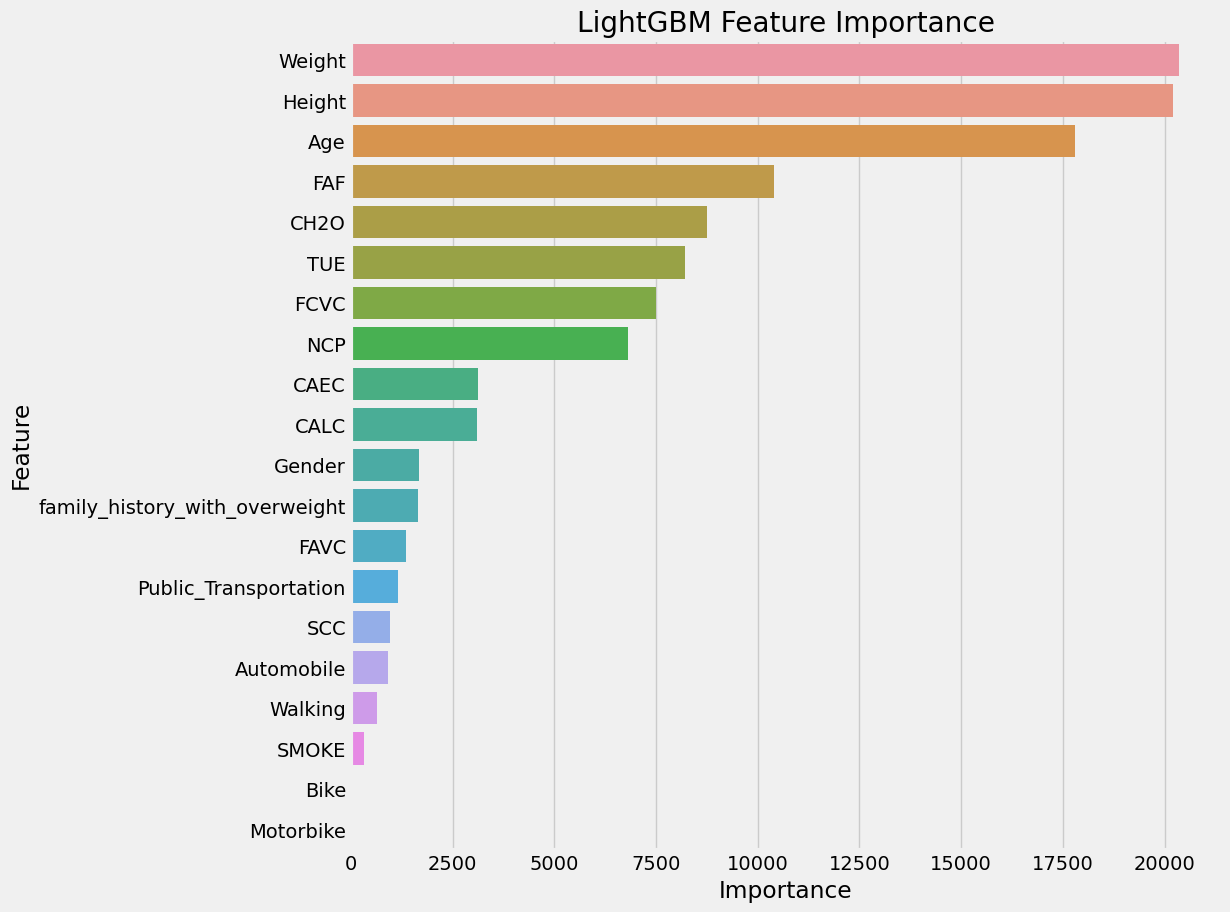

In [38]:
# Get feature importance
feature_importance = clf.feature_importances_

# Create DataFrame 
feature_importance_df = pd.DataFrame({'Feature': list(X_train.columns), 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)#.head(top_n)

plt.figure(figsize=(10, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('LightGBM Feature Importance')
plt.show()
